In [1]:
!pip install -U dask

     |████████████████████████████████| 1.0 MB 4.0 MB/s 
     |████████████████████████████████| 132 kB 68.8 MB/s 
  Attempting uninstall: dask
    Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [3]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [35]:
!pip install phik

     |████████████████████████████████| 675 kB 4.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
# from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# import optuna
# import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from tqdm.notebook import tqdm 

import pickle as pkl

In [36]:
import phik
from phik.report import plot_correlation_matrix

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [6]:
def manage_memory(data):
    ''' Reducing memory of data by changing datatype of column based on their min and max values '''
  
    for col in data:
        column_type = str(data[col].dtype)
        types = ['int16','int32','int64','float16','float32','float64']
        if column_type in types:
            min_value = data[col].min()
            max_value = data[col].max()
      
            if column_type[:3] == 'int':
                if min_value > np.iinfo(np.int8).min and max_value < np.iinfo(np.int8).max:
                    data[col]=data[col].astype(np.int8) 
                elif min_value > np.iinfo(np.int16).min and max_value < np.iinfo(np.int16).max:
                    data[col]=data[col].astype(np.int16)
                elif min_value > np.iinfo(np.int32).min and max_value < np.iinfo(np.int32).max:
                    data[col]=data[col].astype(np.int32)
                elif min_value > np.iinfo(np.int64).min and max_value < np.iinfo(np.int64).max:
                    data[col]=data[col].astype(np.int64)
      
            else:

                if min_value > np.finfo(np.float16).min and max_value < np.finfo(np.float16).max:
                    data[col]=data[col].astype(np.float16) 
                elif min_value > np.finfo(np.float32).min and max_value < np.finfo(np.float32).max:
                    data[col]=data[col].astype(np.float32)
                else:

                    data[col]=data[col].astype(np.float64)
    return data  

In [7]:
data = dd.read_csv('/content/drive/MyDrive/272-TermProject/df_wo_outliers.csv',
                   dtype=dtypes)

In [8]:
cats = list(np.load('/content/drive/MyDrive/272-TermProject/cat_cols.npz')['arr_0'])

In [13]:
nums = list(np.load('/content/drive/MyDrive/272-TermProject/num_cols.npz')['arr_0'])
bools = list(np.load('/content/drive/MyDrive/272-TermProject/boolean_cols.npz')['arr_0'])

In [9]:
data = data.compute()
data = manage_memory(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200776 entries, 0 to 106475
Data columns (total 78 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   EngineVersion                                      category
 2   AppVersion                                         category
 3   AvSigVersion                                       category
 4   IsBeta                                             int8    
 5   RtpStateBitfield                                   float16 
 6   IsSxsPassiveMode                                   int8    
 7   AVProductStatesIdentifier                          float32 
 8   AVProductsInstalled                                float16 
 9   AVProductsEnabled                                  float16 
 10  HasTpm                                             int8    
 11  CountryIdentifier                     

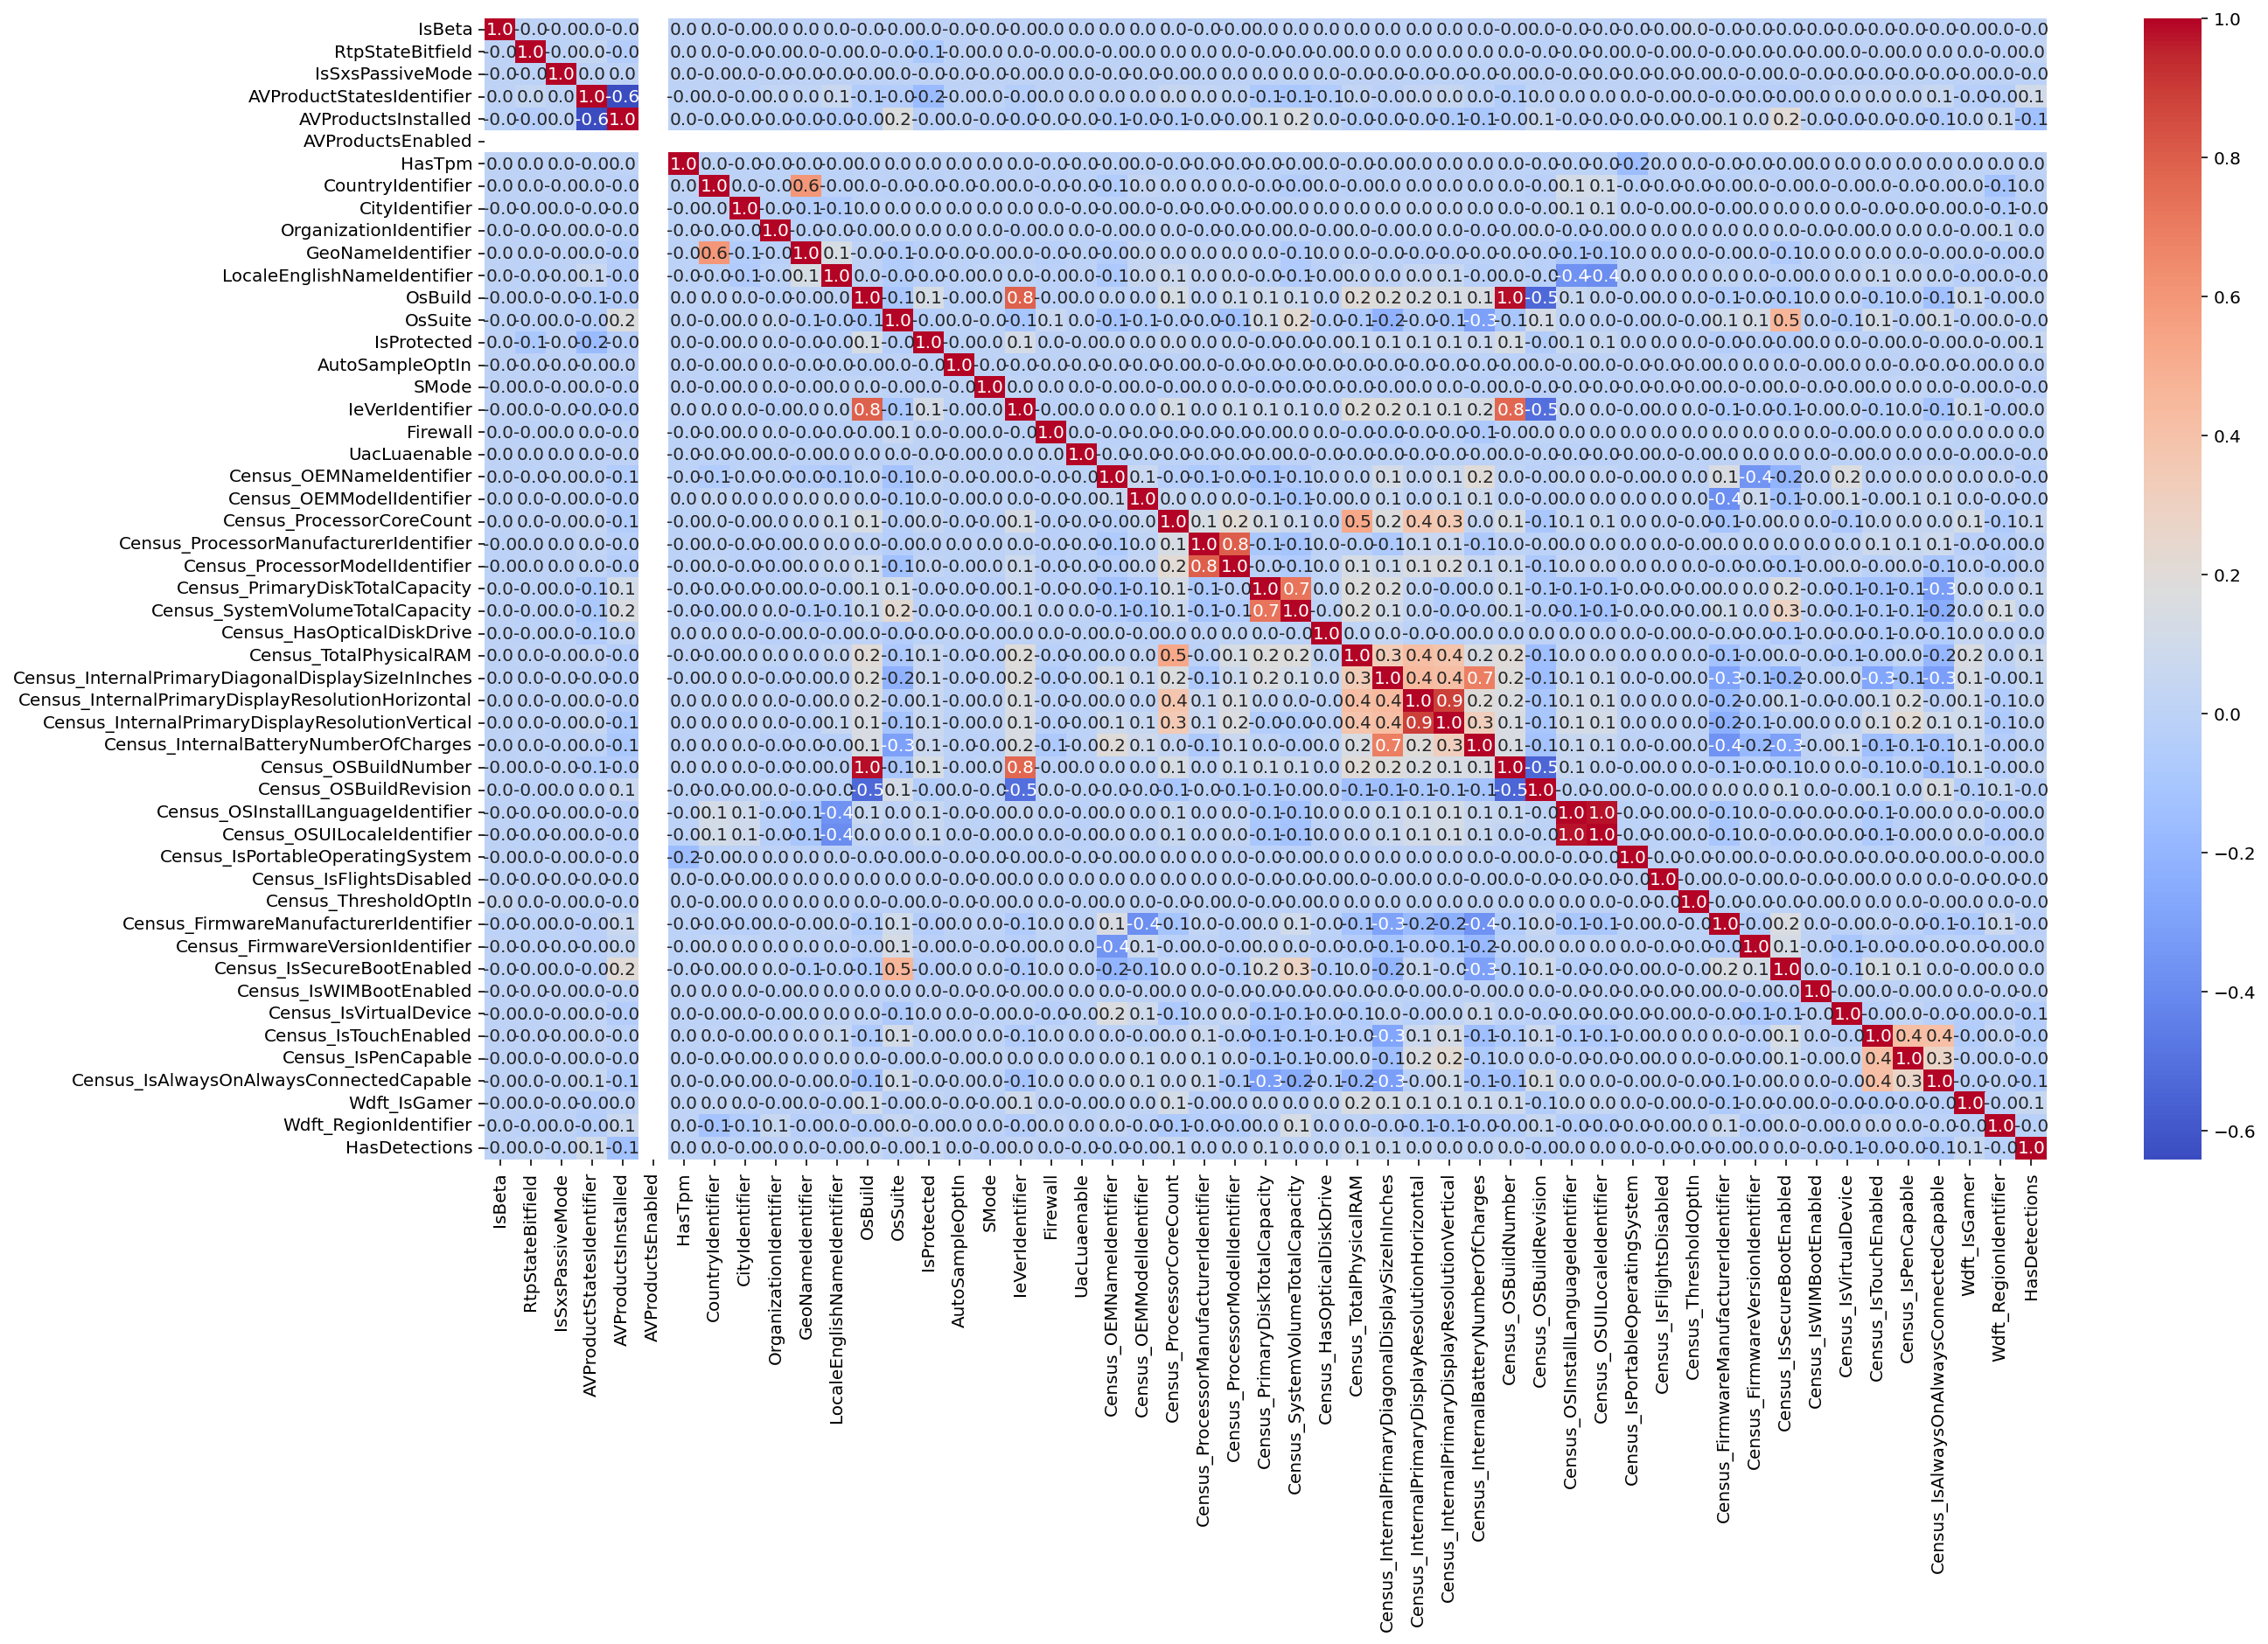

In [12]:
f, ax = plt.subplots(figsize=(20,12))

hm_corr = sns.heatmap(data=data.corr(), annot=True,
                      ax=ax, cmap='coolwarm', fmt='.1f')

There are too many features to interpret the correlations clearly. We can split them into chunks and visualize them

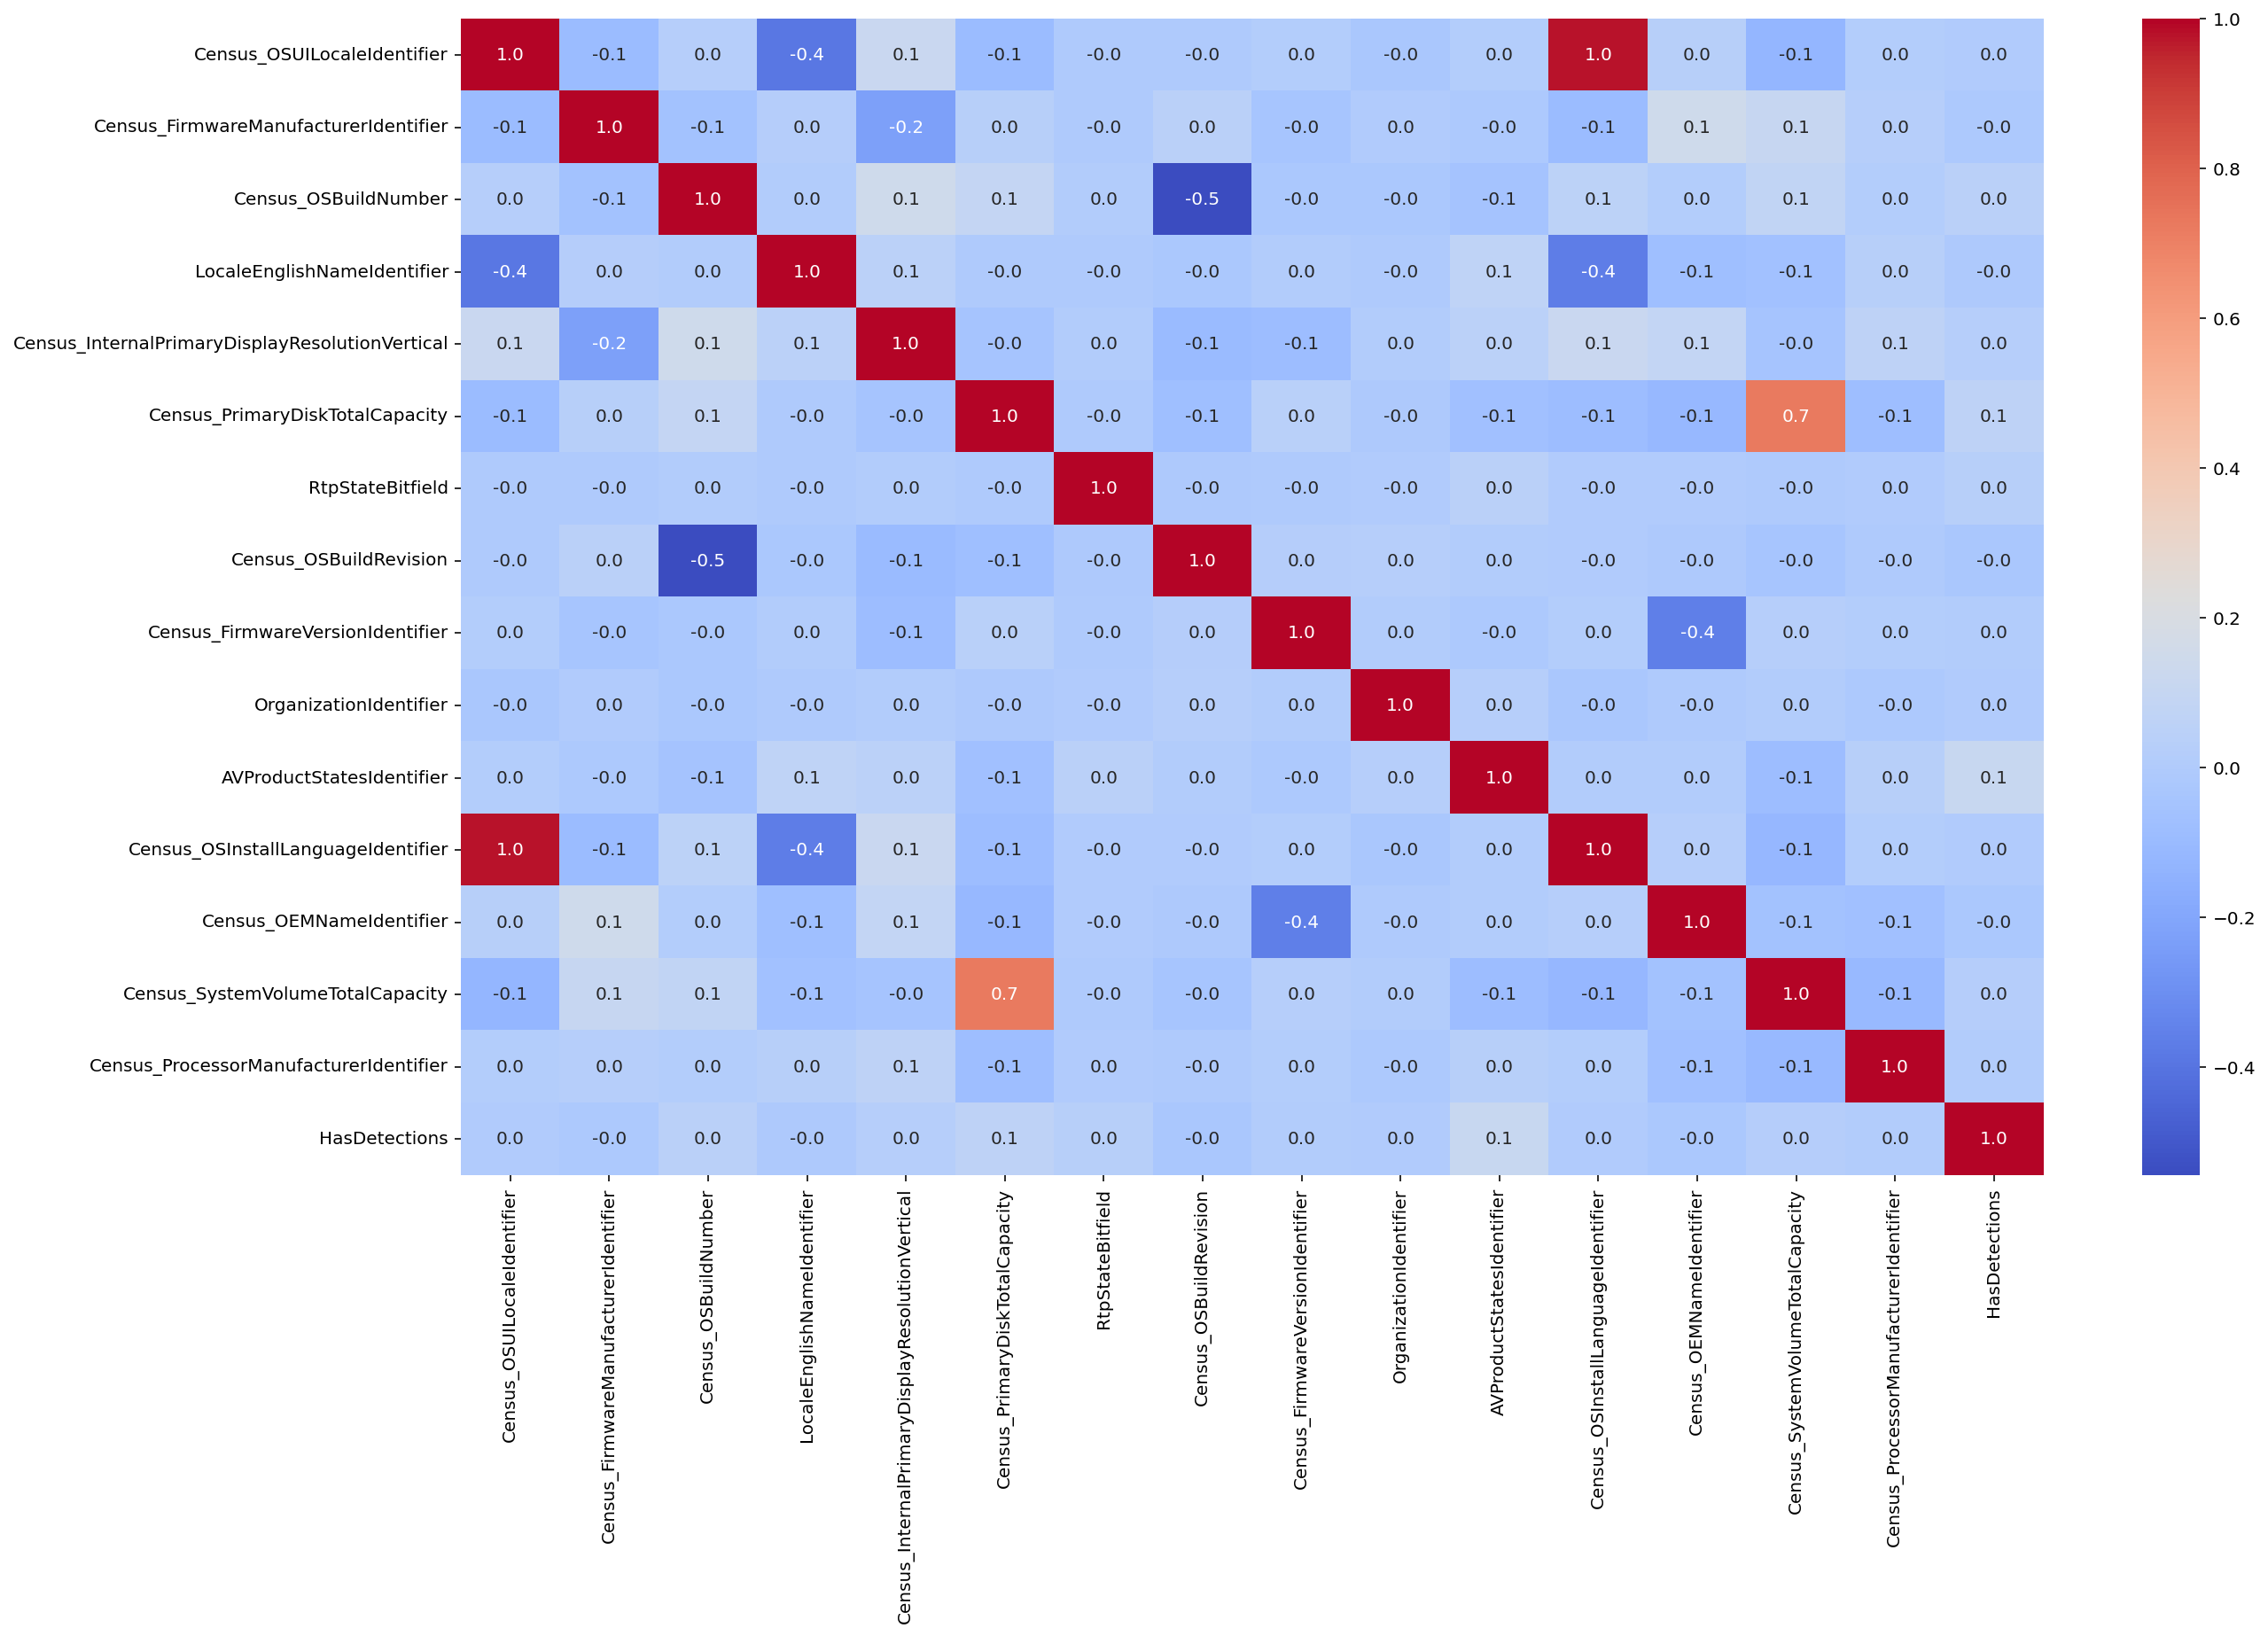

In [17]:
f, ax = plt.subplots(figsize=(20,12))

feats = nums[:15] + ['HasDetections']

sns.heatmap(data=data[feats].corr(), annot=True,
                      ax=ax, cmap='coolwarm', fmt='.1f')

We can observe some highly correlated variables like Census_PrimaryDiskTotalCapacity and Census_SystemVolumeTotalCapacity. Census_OSInstallLanguageIdentifier and Census_OSUILocaleIdentifier are perfectly correlated with a correlation coefficient of 1.0. <br> Highly correlated values tend to dominate the feature space. Hence it is advisable to remove one of them. We will remove Census_SystemVolumeTotalCapacity and Census_OSInstallLanguageIdentifier.

In [18]:
data = data.drop(columns=['Census_SystemVolumeTotalCapacity', 'Census_OSInstallLanguageIdentifier'])

In [22]:
data['AVProductsEnabled']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
106471    1.0
106472    1.0
106473    1.0
106474    1.0
106475    1.0
Name: AVProductsEnabled, Length: 7200776, dtype: float16

In [23]:
nums.remove('AVProductsEnabled')
len(nums)

31

In [26]:
nums[14]

'Census_ProcessorManufacturerIdentifier'

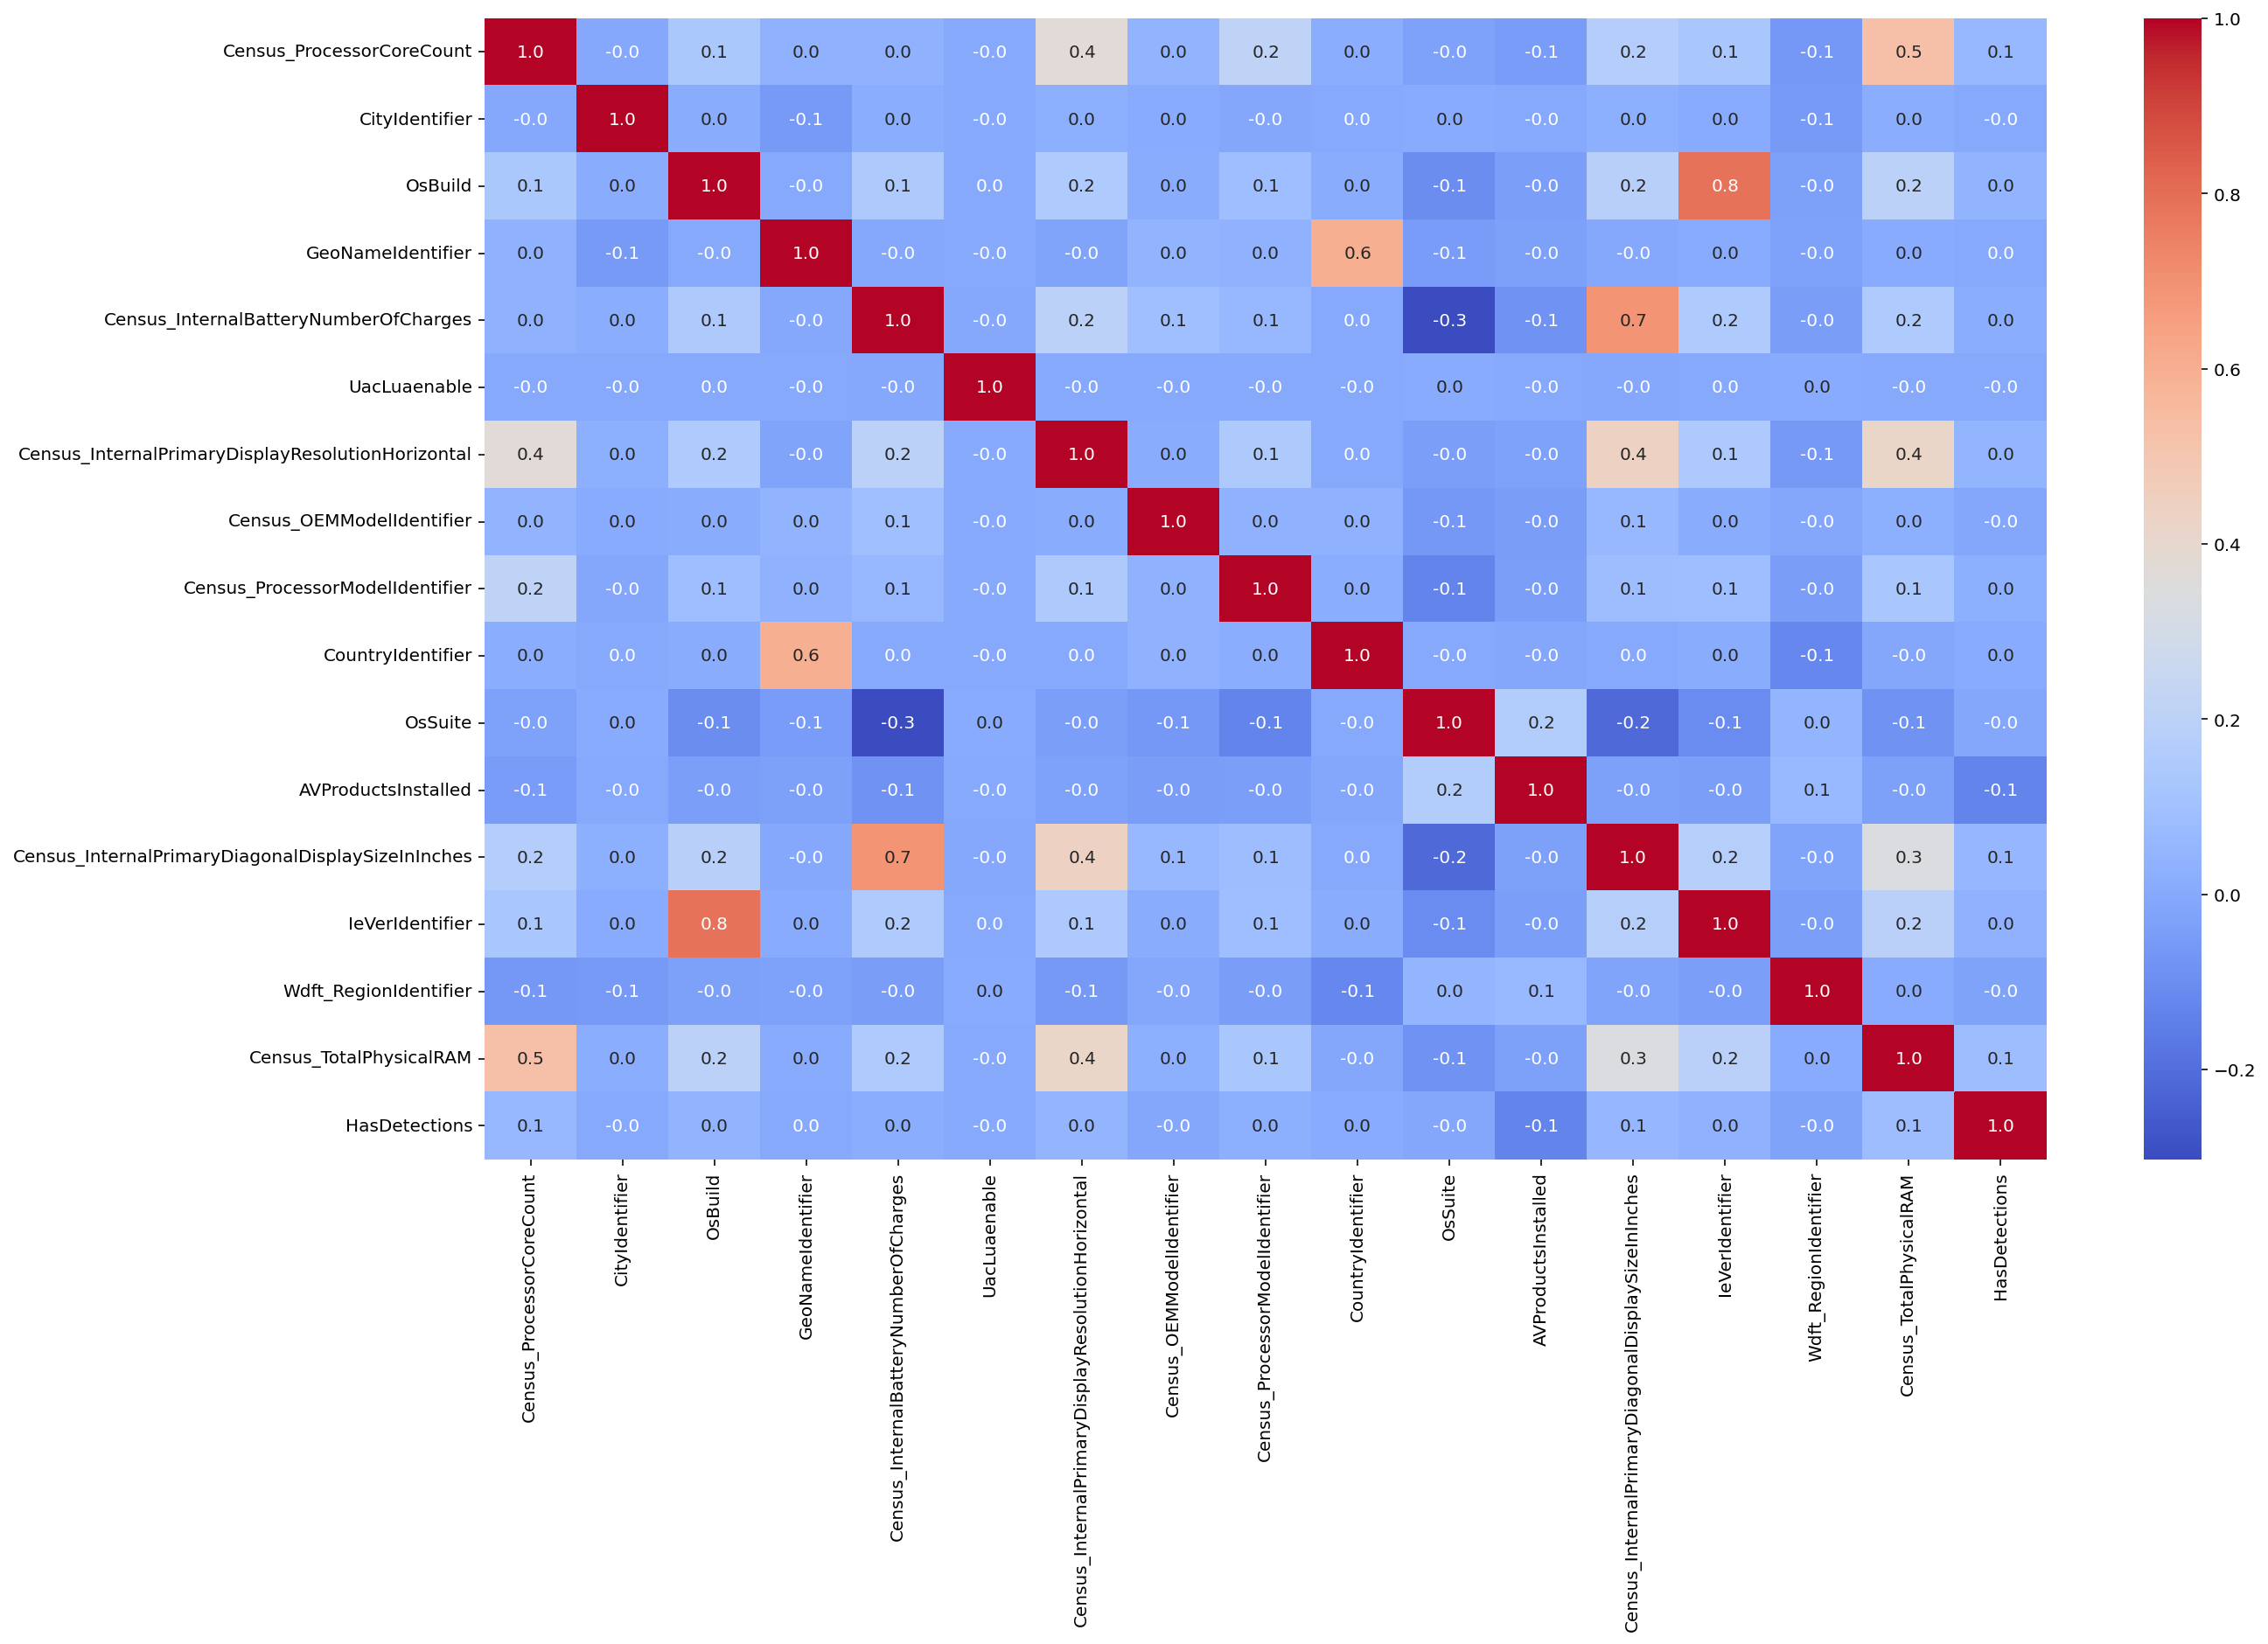

In [27]:
f, ax = plt.subplots(figsize=(20,12))

feats = nums[15:] + ['HasDetections']

sns.heatmap(data=data[feats].corr(), annot=True,
                      ax=ax, cmap='coolwarm', fmt='.1f')

We can observe the following correlations:
<li> IsVerIdentifier and OSBuild
<li> GeoNameIdentifier and CountryIdenitifier
<li> Census_InternalPrimaryDiagonalDisplaySizeInches and Census_InternalBatteryNumberOfCharges

We can remove IsVerIdentifier, GeoNameIdentifier and Census_InternalPrimaryDiagonalDisplaySizeInches

In [30]:
nums.remove('IeVerIdentifier')
nums.remove('GeoNameIdentifier')
nums.remove('Census_InternalPrimaryDiagonalDisplaySizeInInches')

In [31]:
len(nums)

28

Pearson correlation can only be used for numerical variables and it only captures linear relationships. The malware dataset has a lot of categorical features and may have non-linear relationships. So we are using phi-k correlation method 

interval columns not set, guessing: ['HasDetections']


/usr/local/lib/python3.7/dist-packages/phik/data_quality.py:62: UserWarning: The number of unique values of variable AvSigVersion is large: 8338. Are you sure this is not an interval variable? Analysis for pairs of variables including AvSigVersion can be slow.
  col, df[col].nunique()


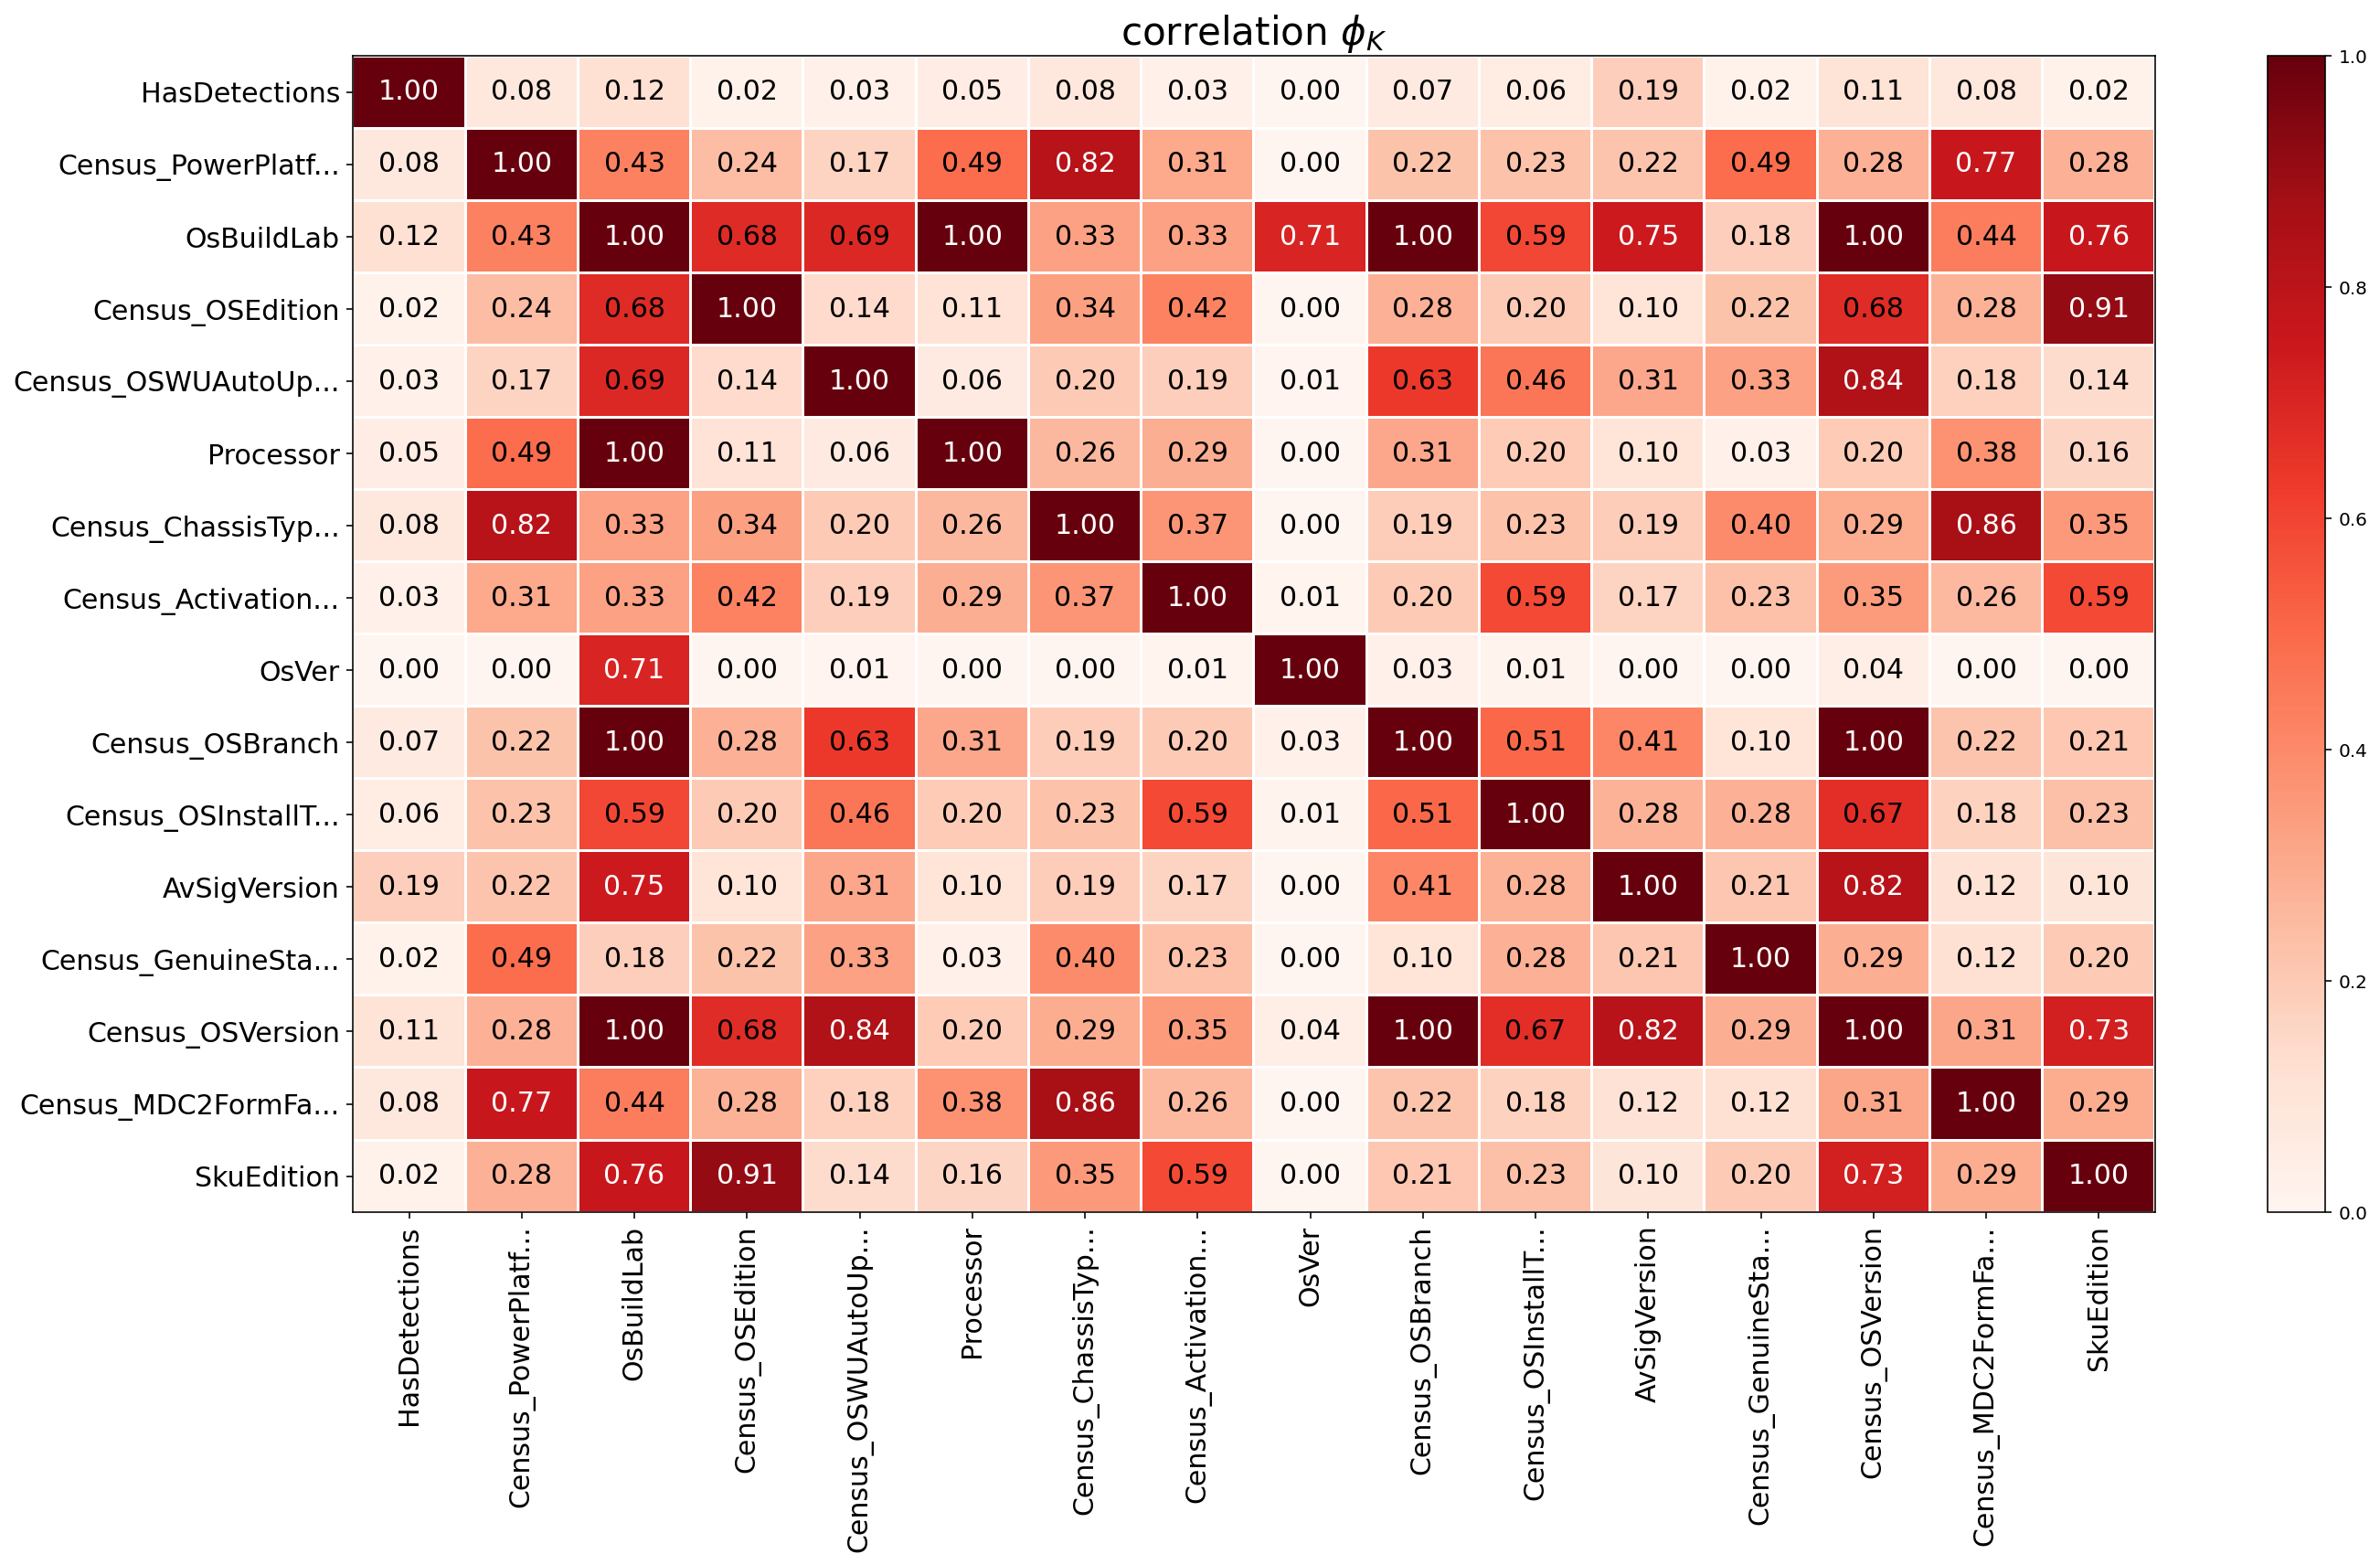

In [38]:
feats = cats[:15] + ['HasDetections']

phik_corr = data[feats].phik_matrix()

plot_correlation_matrix(phik_corr.values, x_labels=phik_corr.columns, y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,12))
plt.tight_layout()

In [39]:
cats[:15]

['SkuEdition',
 'Census_MDC2FormFactor',
 'Census_OSVersion',
 'Census_GenuineStateName',
 'AvSigVersion',
 'Census_OSInstallTypeName',
 'Census_OSBranch',
 'OsVer',
 'Census_ActivationChannel',
 'Census_ChassisTypeName',
 'Processor',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_OSEdition',
 'OsBuildLab',
 'Census_PowerPlatformRoleName']

We can see some strongly correlated features. We will remove the most correlated features.

interval columns not set, guessing: ['HasDetections']


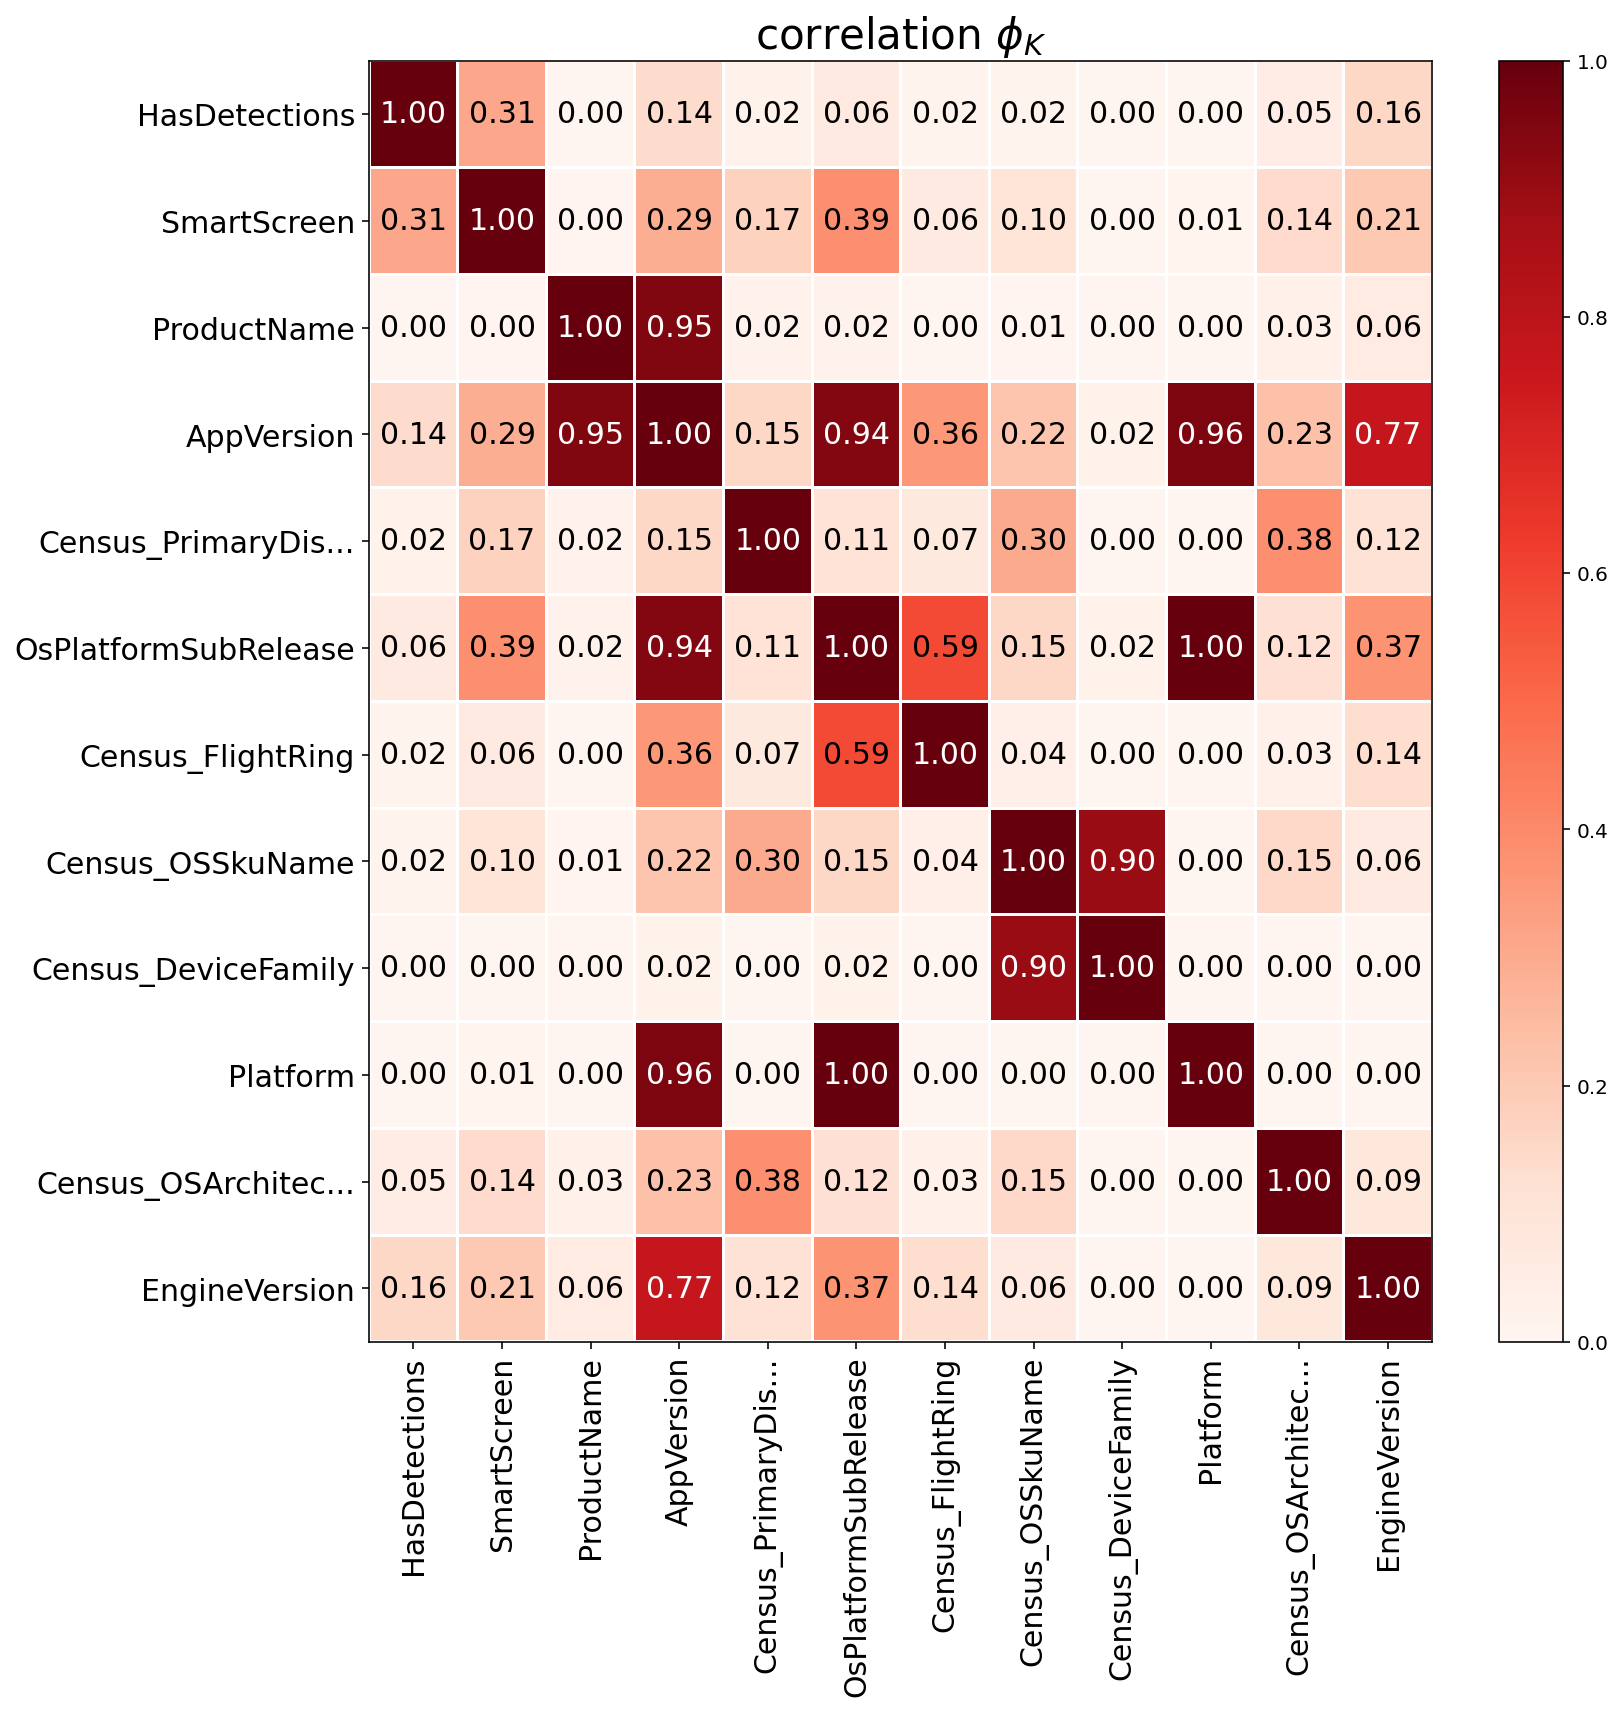

In [43]:
feats = cats[15:] + ['HasDetections']

phik_corr = data[feats].phik_matrix()

plot_correlation_matrix(phik_corr.values, x_labels=phik_corr.columns, y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(12,12))
plt.tight_layout()

In [42]:
cats[15:]

['EngineVersion',
 'Census_OSArchitecture',
 'Platform',
 'Census_DeviceFamily',
 'Census_OSSkuName',
 'Census_FlightRing',
 'OsPlatformSubRelease',
 'Census_PrimaryDiskTypeName',
 'AppVersion',
 'ProductName',
 'SmartScreen']

In [44]:
cats.remove('Census_PowerPlatformRoleName')
cats.remove('Census_MDC2FormFactor')
cats.remove('SkuEdition')
cats.remove('Census_OSBranch')
cats.remove('Census_ActivationChannel')
cats.remove('ProductName')
cats.remove('OsPlatformSubRelease')
cats.remove('Census_DeviceFamily')

interval columns not set, guessing: ['IsBeta', 'IsSxsPassiveMode', 'HasTpm', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'Firewall', 'Census_HasOpticalDiskDrive', 'Census_IsPortableOperatingSystem', 'Census_IsFlightsDisabled', 'Census_ThresholdOptIn', 'Census_IsSecureBootEnabled', 'Census_IsWIMBootEnabled', 'Census_IsVirtualDevice', 'Census_IsTouchEnabled', 'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer', 'HasDetections']


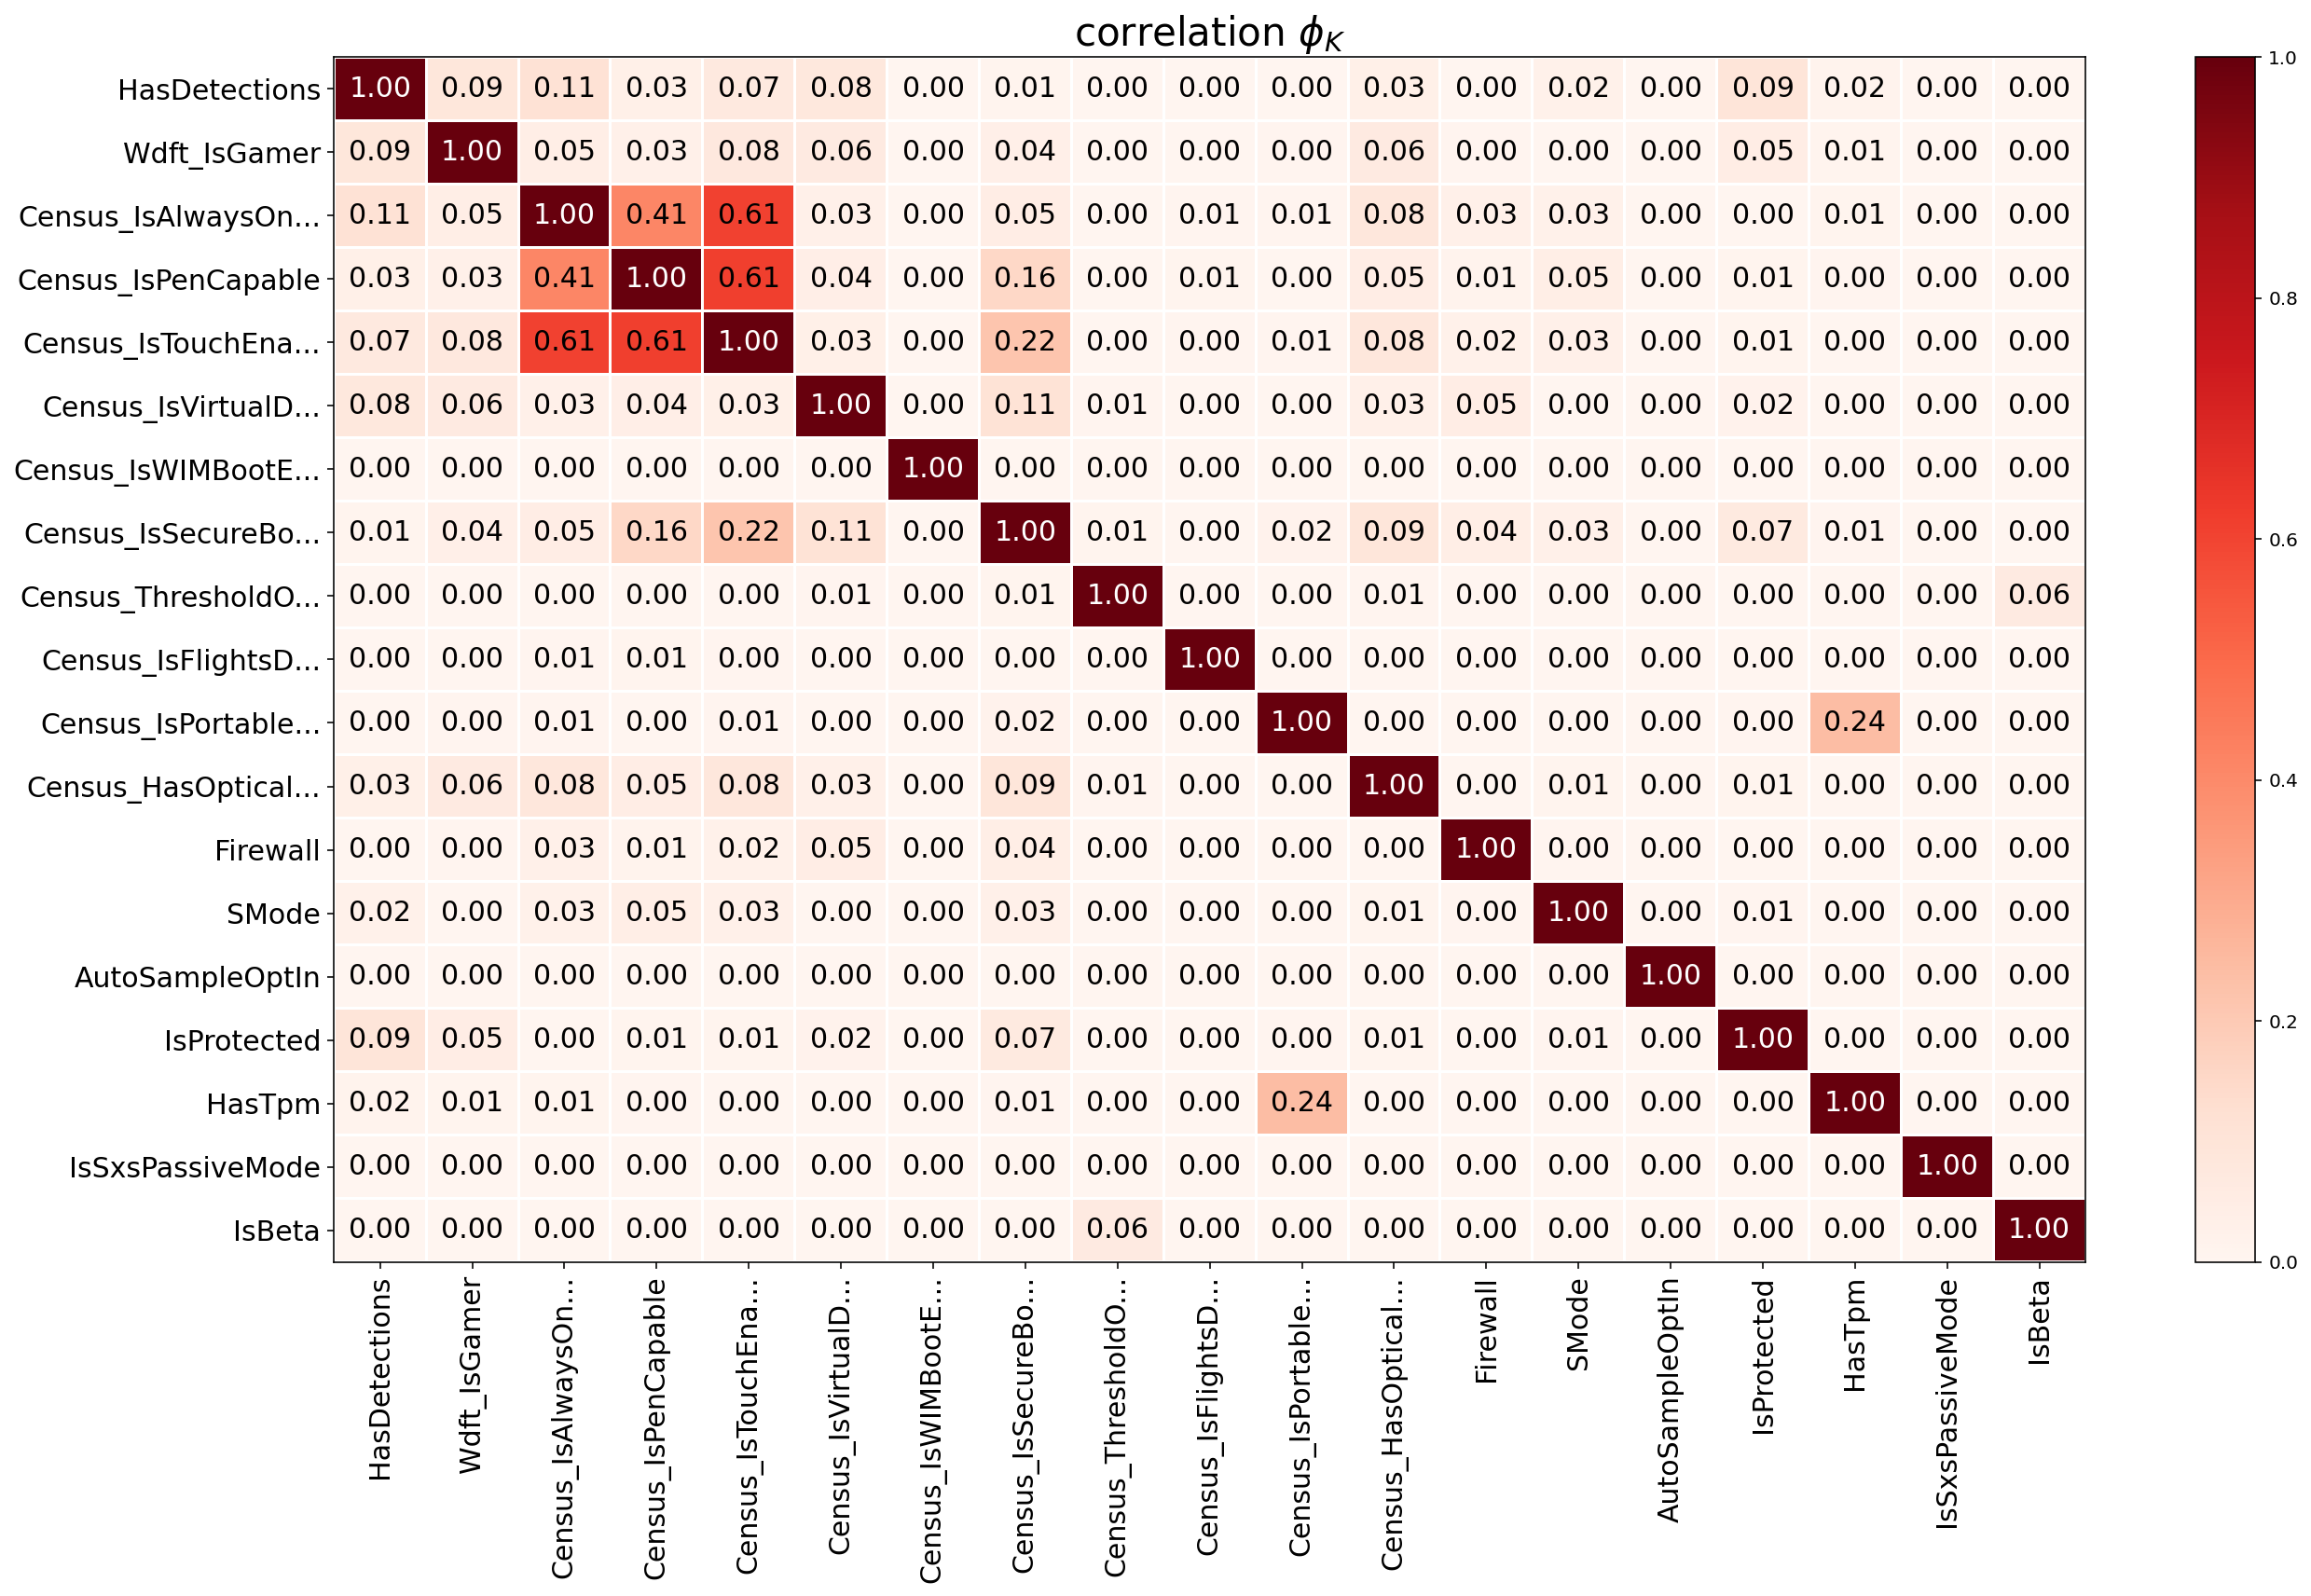

In [45]:
feats = bools + ['HasDetections']

phik_corr = data[feats].phik_matrix()

plot_correlation_matrix(phik_corr.values, x_labels=phik_corr.columns, y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(19,12))
plt.tight_layout()

In [46]:
bools

['IsBeta',
 'IsSxsPassiveMode',
 'HasTpm',
 'IsProtected',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_ThresholdOptIn',
 'Census_IsSecureBootEnabled',
 'Census_IsWIMBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer']

In [47]:
# retaining the variable that is highly correlated with target and removing the rest
bools.remove('Census_IsPenCapable')
bools.remove('Census_IsTouchEnabled')

In [48]:
final_features = cats + nums + bools
final_features

['Census_OSVersion',
 'Census_GenuineStateName',
 'AvSigVersion',
 'Census_OSInstallTypeName',
 'OsVer',
 'Census_ChassisTypeName',
 'Processor',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_OSEdition',
 'OsBuildLab',
 'EngineVersion',
 'Census_OSArchitecture',
 'Platform',
 'Census_OSSkuName',
 'Census_FlightRing',
 'Census_PrimaryDiskTypeName',
 'AppVersion',
 'SmartScreen',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_OSBuildNumber',
 'LocaleEnglishNameIdentifier',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_PrimaryDiskTotalCapacity',
 'RtpStateBitfield',
 'Census_OSBuildRevision',
 'Census_FirmwareVersionIdentifier',
 'OrganizationIdentifier',
 'AVProductStatesIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OEMNameIdentifier',
 'Census_SystemVolumeTotalCapacity',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorCoreCount',
 'CityIdentifier',
 'OsBuild',
 'Census_InternalBatteryNumberOfCharges',
 'UacLu

In [49]:
len(final_features)

62

In [50]:
data.columns

Index(['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta',
       'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'SMode',
       'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName', 'Census_HasOpticalDiskDrive',
       'Census_TotalPhysicalRAM', 'Census_ChassisTypeName',
       'Census_Int

In [51]:
final_features = final_features + ['MachineIdentifier', 'HasDetections']
len(final_features)

64

In [55]:
final_features.remove('Census_OSInstallLanguageIdentifier')
final_features.remove('Census_SystemVolumeTotalCapacity')

nums.remove('Census_OSInstallLanguageIdentifier')
nums.remove('Census_SystemVolumeTotalCapacity')

In [56]:
# save the features as a numpy array separately
np.savez('/content/drive/MyDrive/272-TermProject/cat_cols_f', cats)
np.savez('/content/drive/MyDrive/272-TermProject/boolean_cols_f', bools)
np.savez('/content/drive/MyDrive/272-TermProject/num_cols_f', nums)

In [57]:
final_features

['Census_OSVersion',
 'Census_GenuineStateName',
 'AvSigVersion',
 'Census_OSInstallTypeName',
 'OsVer',
 'Census_ChassisTypeName',
 'Processor',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_OSEdition',
 'OsBuildLab',
 'EngineVersion',
 'Census_OSArchitecture',
 'Platform',
 'Census_OSSkuName',
 'Census_FlightRing',
 'Census_PrimaryDiskTypeName',
 'AppVersion',
 'SmartScreen',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_OSBuildNumber',
 'LocaleEnglishNameIdentifier',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_PrimaryDiskTotalCapacity',
 'RtpStateBitfield',
 'Census_OSBuildRevision',
 'Census_FirmwareVersionIdentifier',
 'OrganizationIdentifier',
 'AVProductStatesIdentifier',
 'Census_OEMNameIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorCoreCount',
 'CityIdentifier',
 'OsBuild',
 'Census_InternalBatteryNumberOfCharges',
 'UacLuaenable',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_OEM

In [58]:
final_train = data[final_features]

final_train.to_csv('/content/drive/MyDrive/272-TermProject/final_train.csv',
                   index=False)

# Visualization

Sample 50k records to perform some preliminary data visualizations. We see that the data is almost equally distributed based on presence of malware infections

In [62]:
data_df = data[:50000]

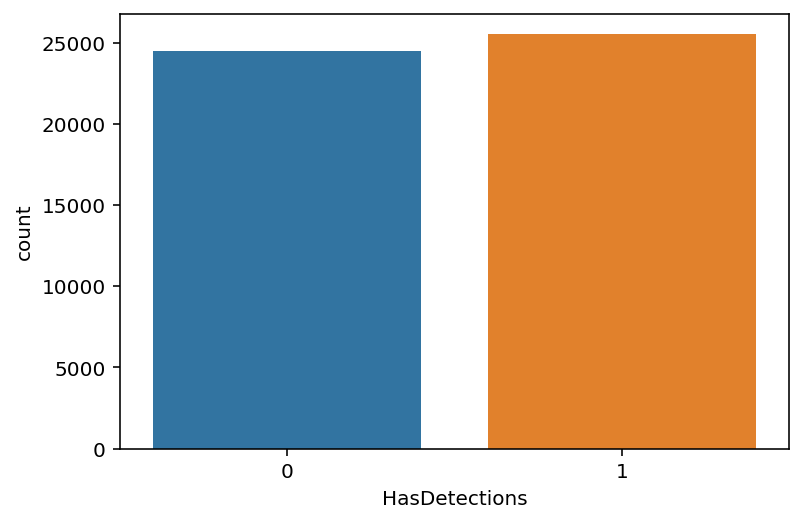

In [63]:
sns.countplot(data=data_df, x='HasDetections')

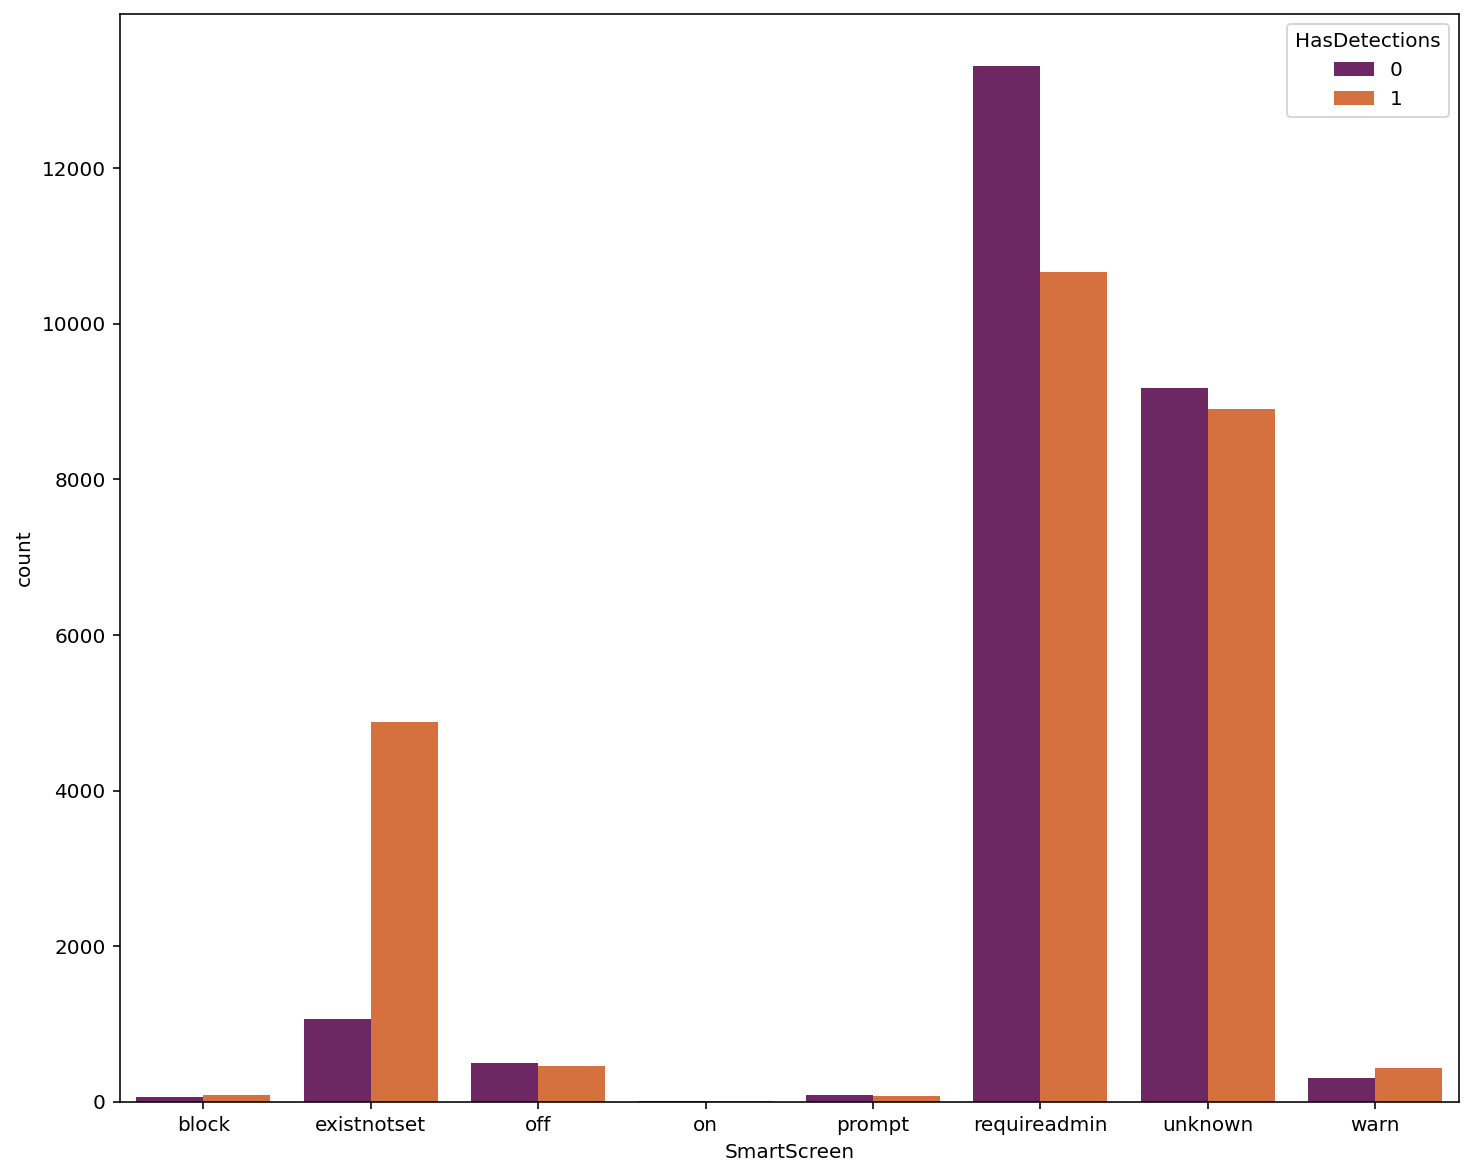

In [64]:
plt.figure(figsize = (12,10))
sns.countplot(x="SmartScreen",hue='HasDetections',data=data_df, palette='inferno')

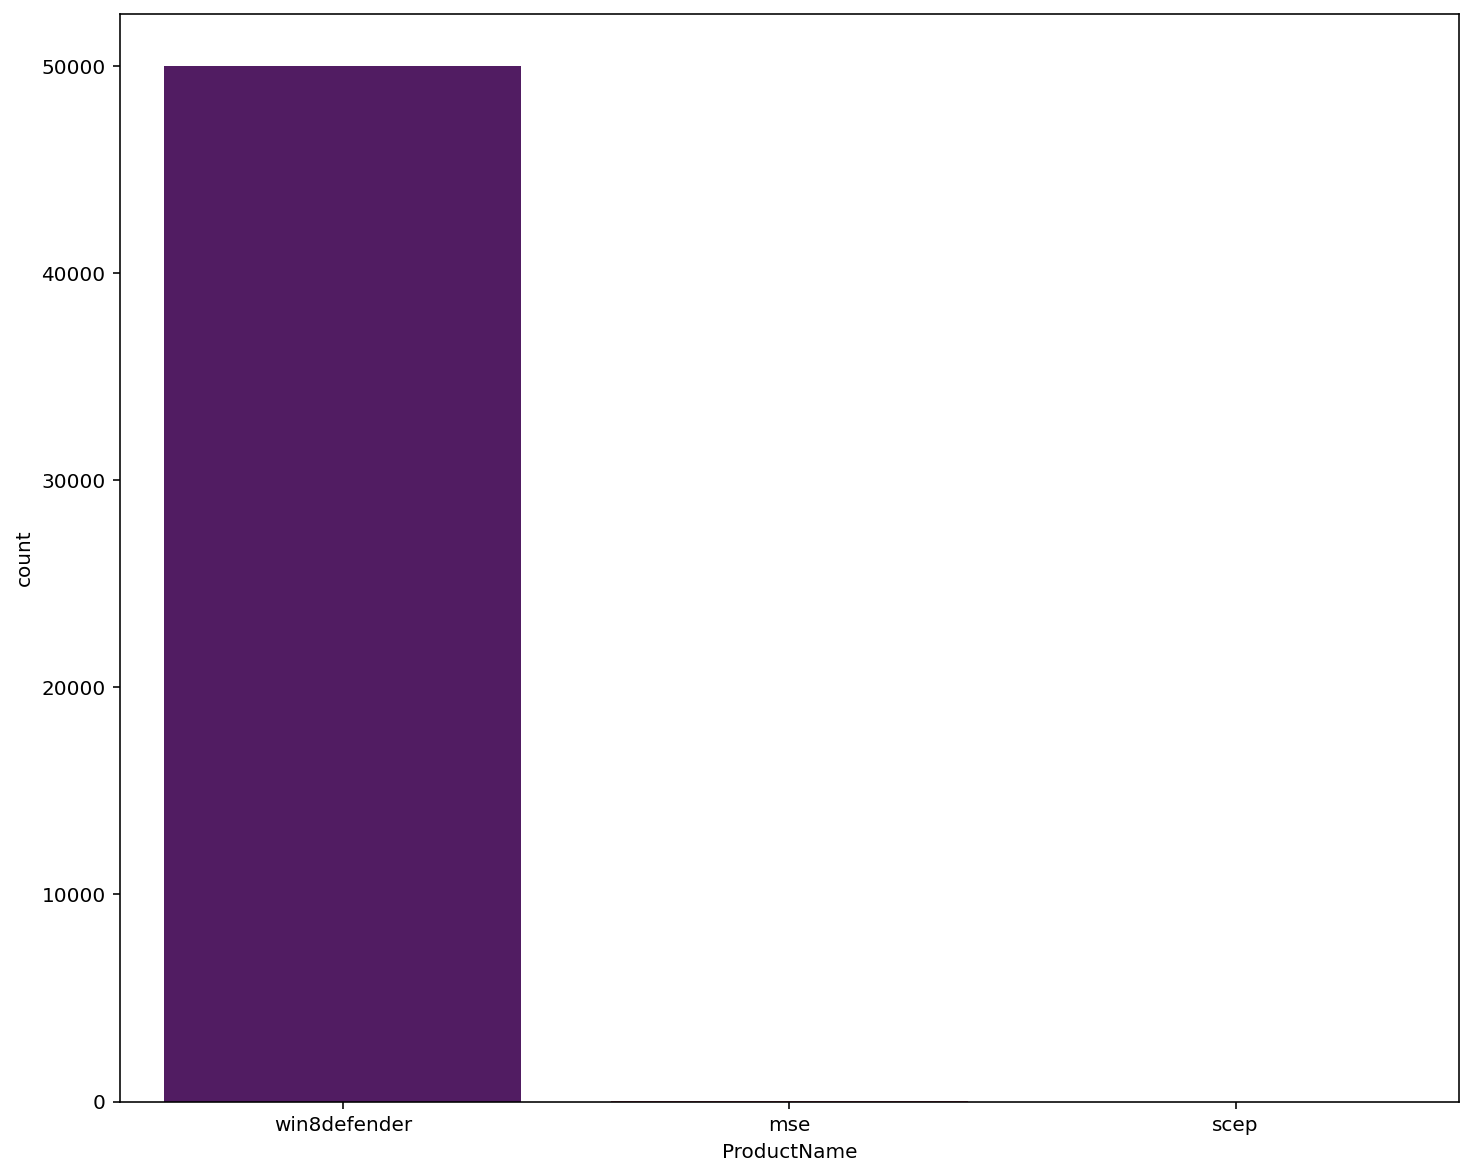

In [65]:
plt.figure(figsize = (12,10))
sns.countplot(x="ProductName",data=data_df, palette='inferno')

<Figure size 432x288 with 0 Axes>

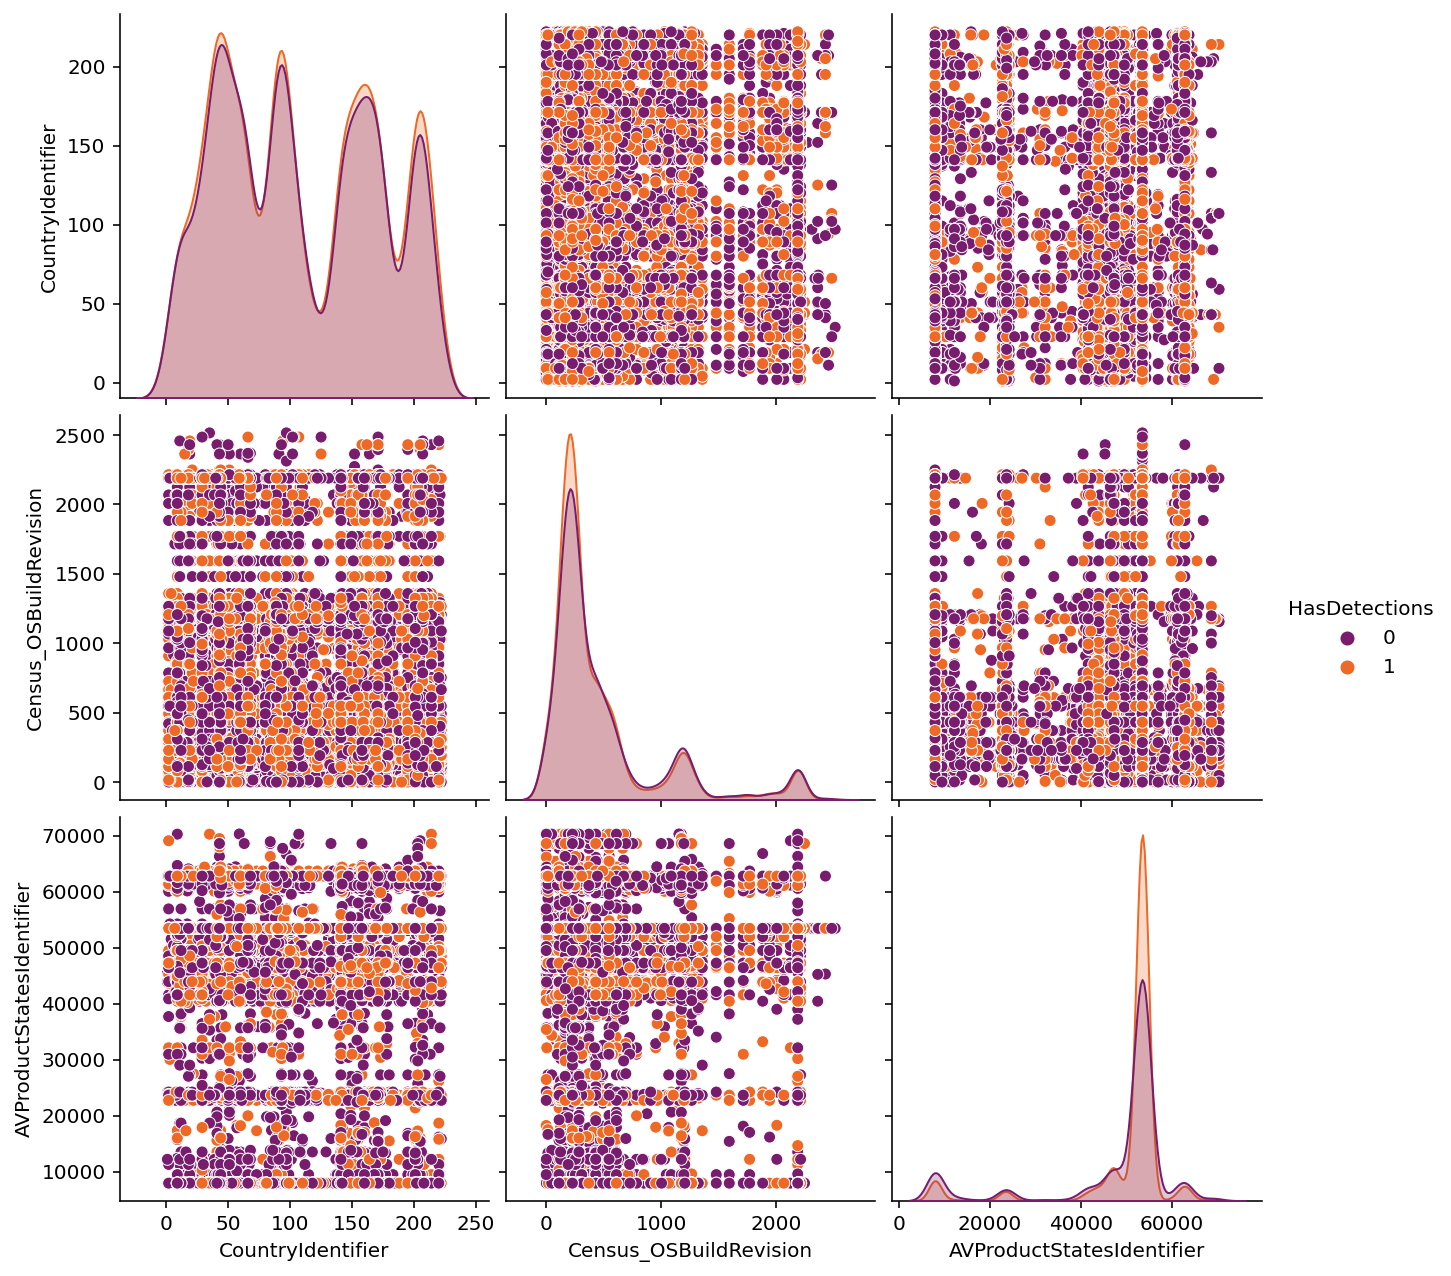

In [68]:
feature = ['CountryIdentifier','Census_OSBuildRevision','AVProductStatesIdentifier','HasDetections']
d = data_df[feature]

plt.figure()
sns.pairplot(d,height=3.0,hue='HasDetections',palette='inferno')

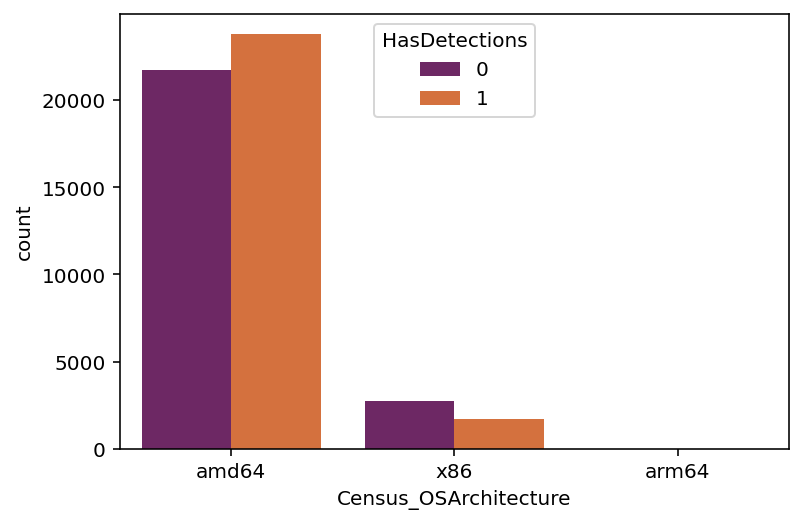

In [69]:
sns.countplot(x='Census_OSArchitecture',hue='HasDetections',data=data_df,palette='inferno')

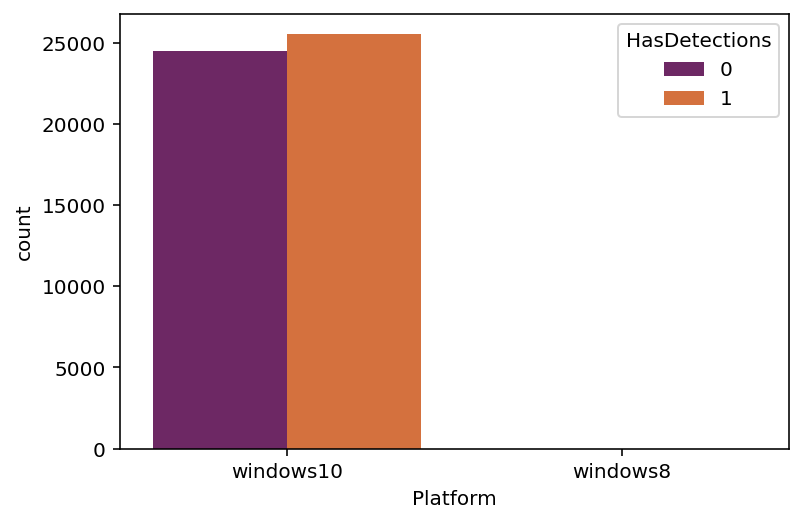

In [78]:
sns.countplot(x='Platform',data=data_df,palette='inferno', hue='HasDetections')

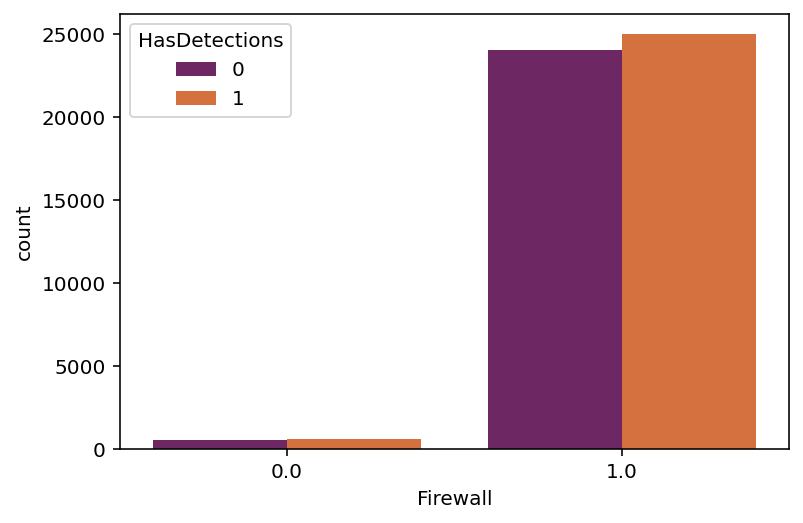

In [79]:
sns.countplot(x='Firewall', data=data_df, palette='inferno', hue='HasDetections')

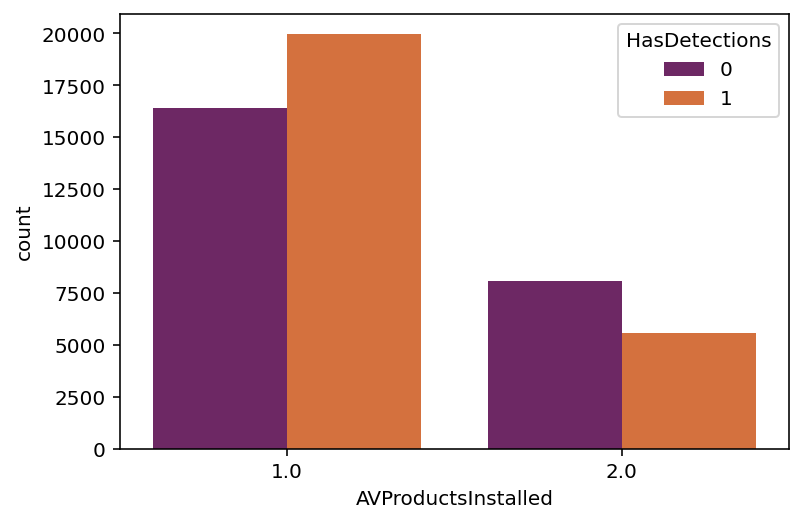

In [80]:
sns.countplot(x='AVProductsInstalled', hue='HasDetections',data=data_df, palette='inferno')

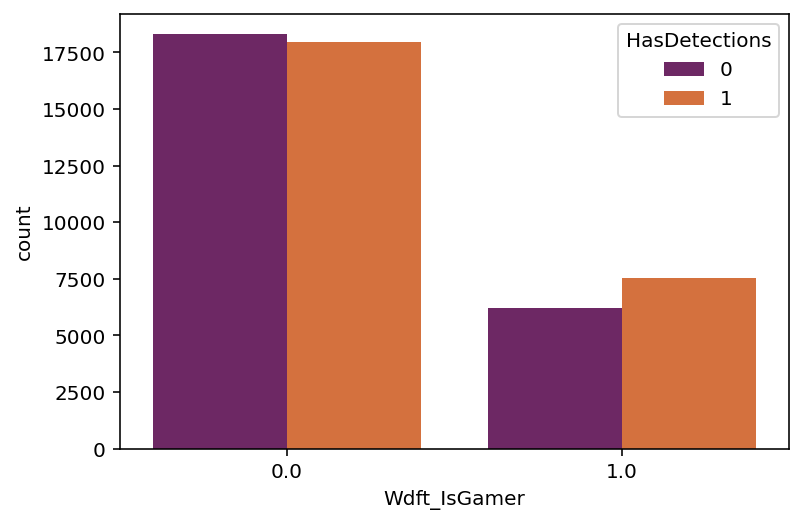

In [81]:
sns.countplot(x='Wdft_IsGamer', hue='HasDetections', data=data_df, palette='inferno')